# Build a Conditional GAN

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [ ]:
class Generator(nn.Module):

    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):

        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    return torch.randn(n_samples, input_dim, device=device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:


import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    return F.one_hot(labels,n_classes)


In [ ]:

def combine_vectors(x, y):
    combined = torch.cat((x.float(),y.float()), 1)
    return combined

In [ ]:
mnist_shape = (1, 28, 28)
n_classes = 9

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/augmentedDataLimitedClasses-2

Streaming output truncated to the last 5000 lines.
 extracting: augmentedDataLimitedClasses-2/twa/1 (325)rotatedCounterClock5.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (325)shiftedDown.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (325)shiftedLeft.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (325)shiftedRight.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (325)shiftedUp.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (326)original.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (326)rotatedClock10.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (326)rotatedClock5.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (326)rotatedCounterClock10.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (326)rotatedCounterClock5.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (326)shiftedDown.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (326)shiftedLeft.jpg  
 extracting: augmentedDataLimitedClasses-2/twa/1 (326)sh

In [ ]:
import torchvision
from torchvision import transforms
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    
    transforms.Grayscale(num_output_channels=1)
    
])

train_data = torchvision.datasets.ImageFolder(root='/content/augmentedDataLimitedClasses-2', transform=transform)

dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
for i in dataloader:
    print(i[1][0])
    break

tensor(8)


In [ ]:

def get_input_dimensions(z_dim, mnist_shape, n_classes):

    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [ ]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [ ]:
from torchvision import models
from torchsummary import summary

print(gen)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(73, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)


In [ ]:
print(disc)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
    )
  )
)


  0%|          | 0/465 [00:00<?, ?it/s]

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!


  0%|          | 0/465 [00:00<?, ?it/s]

Step 500: Generator loss: 1.0928750549554824, discriminator loss: 0.5232875780463219


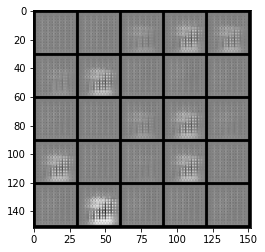

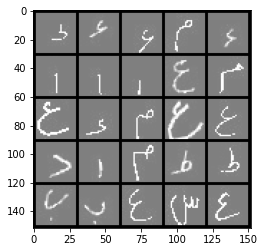

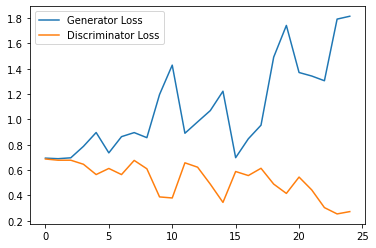

  0%|          | 0/465 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.1972174699306488, discriminator loss: 0.5491703045666217


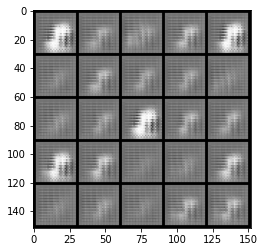

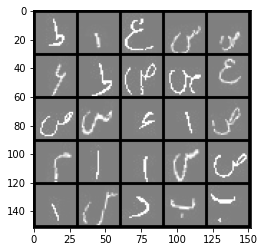

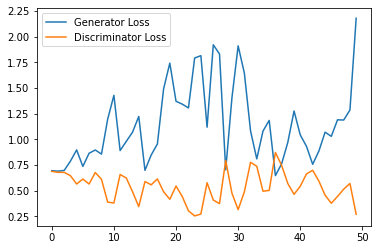

  0%|          | 0/465 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.3537639050483703, discriminator loss: 0.47457782688736916


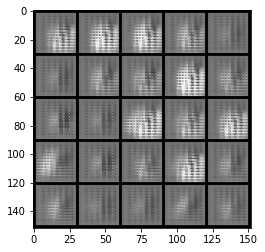

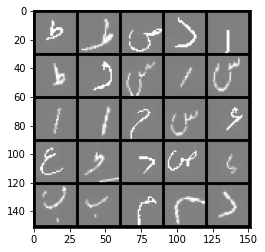

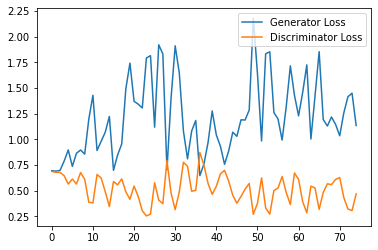

  0%|          | 0/465 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.3392134492397307, discriminator loss: 0.4565948912501335


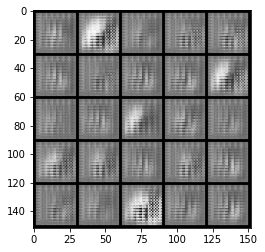

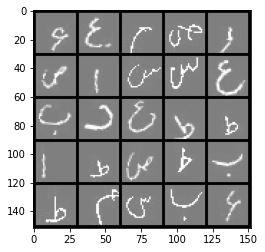

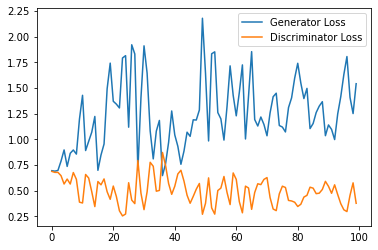

  0%|          | 0/465 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.142939086675644, discriminator loss: 0.5519545856118202


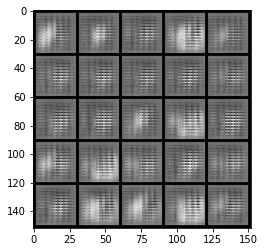

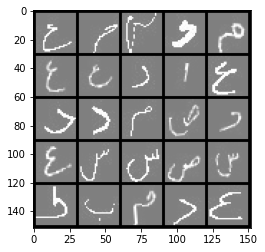

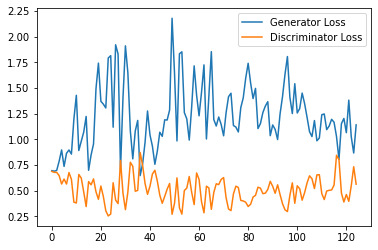

  0%|          | 0/465 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.1167840898036956, discriminator loss: 0.5657273333668709


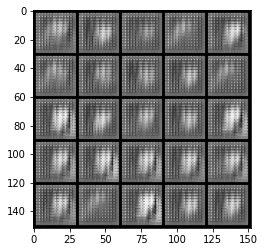

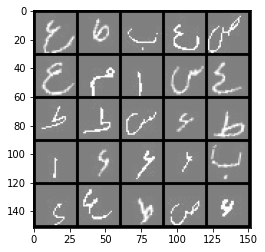

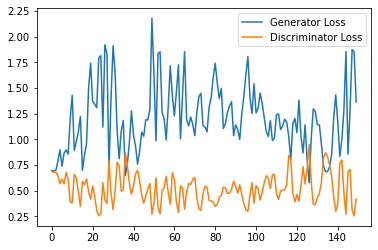

  0%|          | 0/465 [00:00<?, ?it/s]

Step 3500: Generator loss: 1.2888161909580231, discriminator loss: 0.49983119505643847


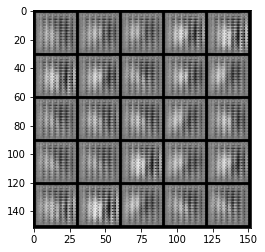

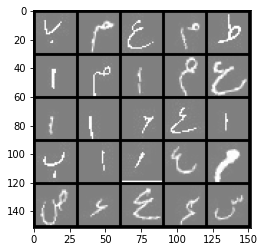

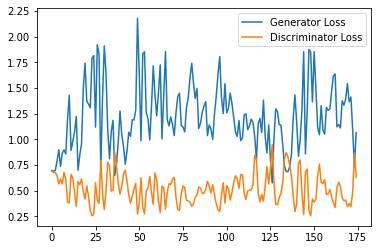

  0%|          | 0/465 [00:00<?, ?it/s]

Step 4000: Generator loss: 1.311715678691864, discriminator loss: 0.47367956244945525


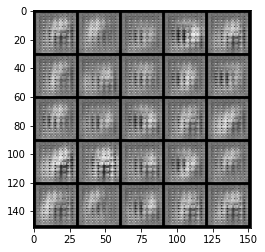

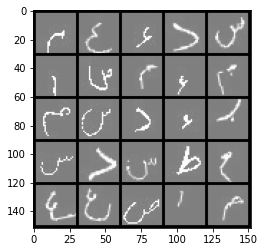

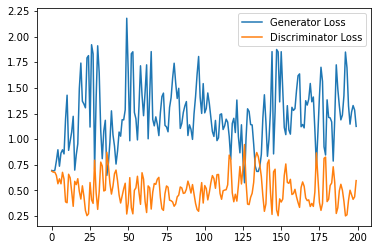

  0%|          | 0/465 [00:00<?, ?it/s]

Step 4500: Generator loss: 1.3022225819826125, discriminator loss: 0.49495944768190386


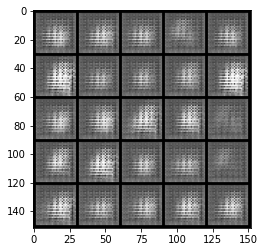

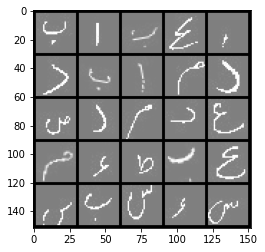

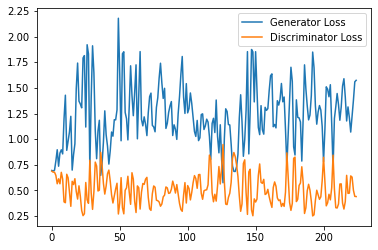

  0%|          | 0/465 [00:00<?, ?it/s]

Step 5000: Generator loss: 1.4105629514455795, discriminator loss: 0.44992032361030576


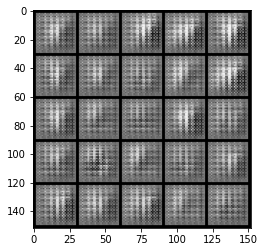

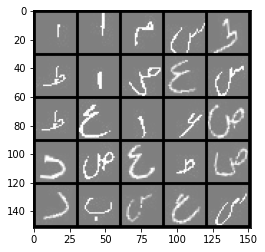

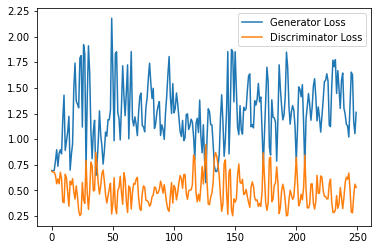

  0%|          | 0/465 [00:00<?, ?it/s]

Step 5500: Generator loss: 1.3867329831123352, discriminator loss: 0.46170345026254656


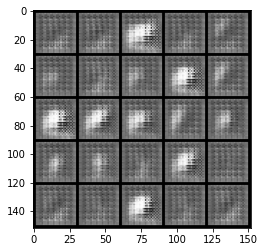

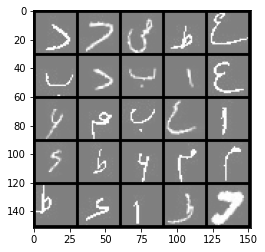

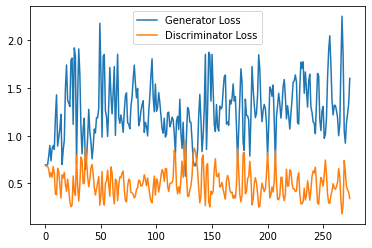

  0%|          | 0/465 [00:00<?, ?it/s]

Step 6000: Generator loss: 1.3779317697286606, discriminator loss: 0.4731424899399281


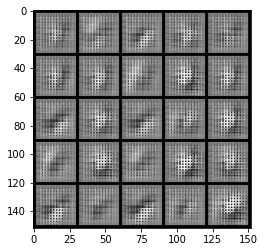

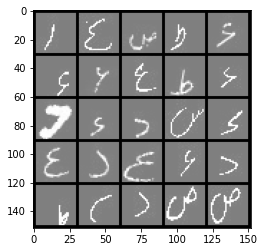

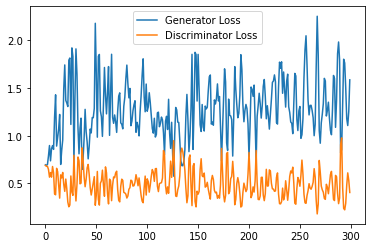

  0%|          | 0/465 [00:00<?, ?it/s]

Step 6500: Generator loss: 1.290506938815117, discriminator loss: 0.4970830841064453


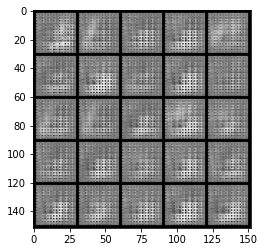

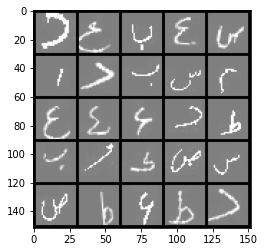

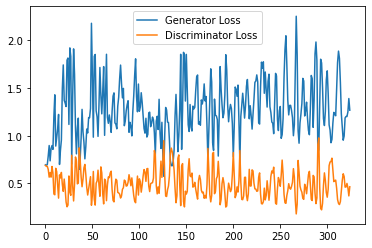

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

Step 7000: Generator loss: 1.1206768293380738, discriminator loss: 0.5542421084046364


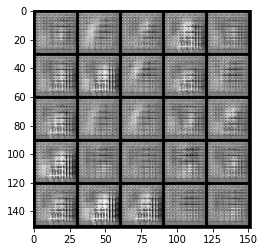

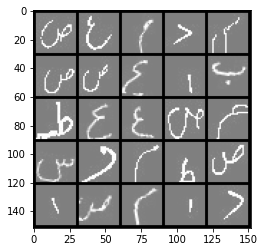

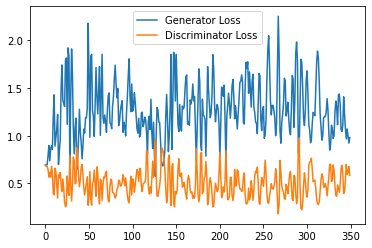

  0%|          | 0/465 [00:00<?, ?it/s]

Step 7500: Generator loss: 1.3244925875663758, discriminator loss: 0.44043615195155145


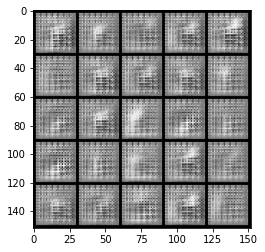

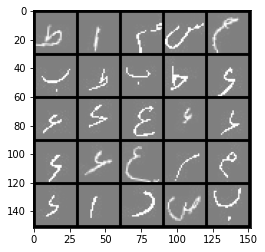

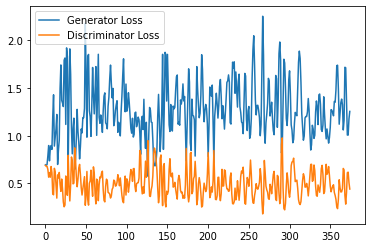

  0%|          | 0/465 [00:00<?, ?it/s]

Step 8000: Generator loss: 1.1717068642377853, discriminator loss: 0.5252083843946457


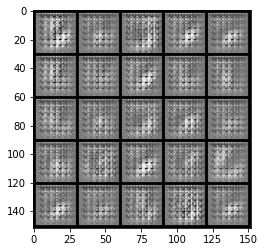

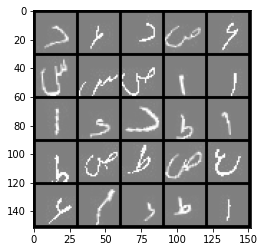

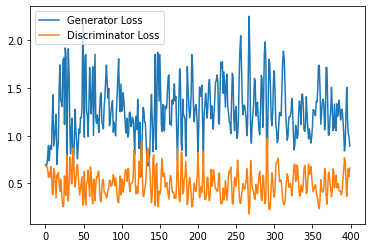

  0%|          | 0/465 [00:00<?, ?it/s]

Step 8500: Generator loss: 1.0493328733444214, discriminator loss: 0.5567009807229042


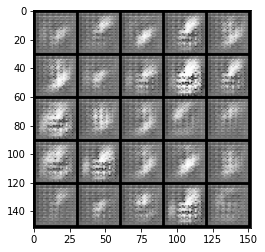

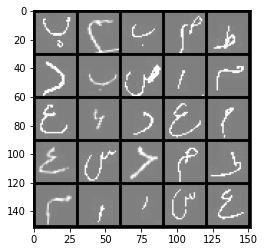

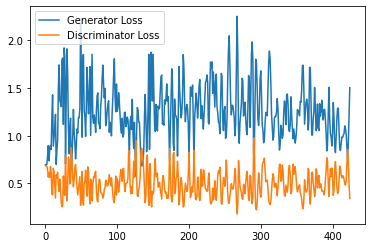

  0%|          | 0/465 [00:00<?, ?it/s]

Step 9000: Generator loss: 1.0963798042535782, discriminator loss: 0.5351075242161751


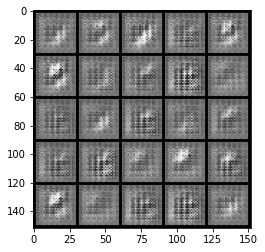

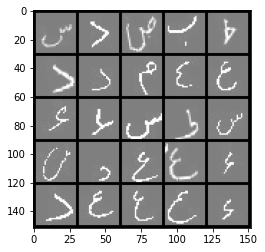

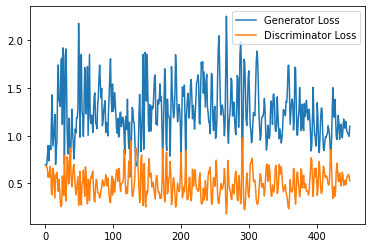

  0%|          | 0/465 [00:00<?, ?it/s]

Step 9500: Generator loss: 1.3609343813657762, discriminator loss: 0.44278963619470596


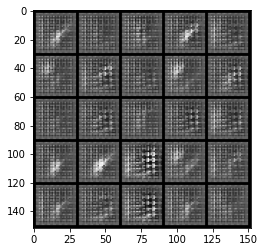

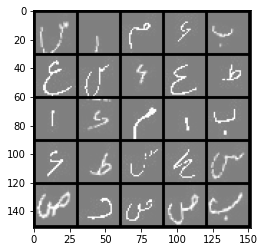

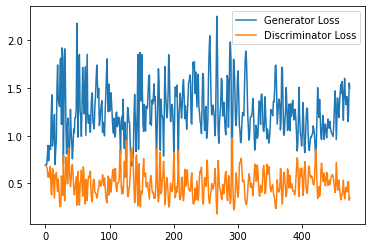

  0%|          | 0/465 [00:00<?, ?it/s]

Step 10000: Generator loss: 1.31887852871418, discriminator loss: 0.4677569490671158


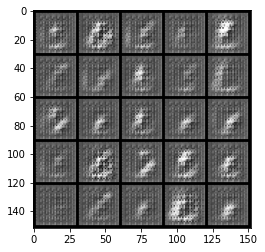

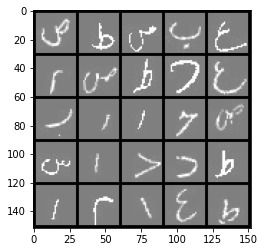

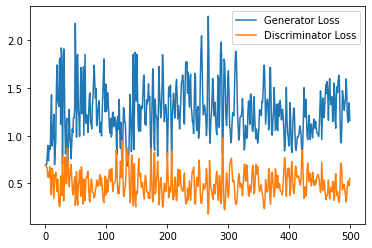

  0%|          | 0/465 [00:00<?, ?it/s]

Step 10500: Generator loss: 1.3034879570007325, discriminator loss: 0.45243116611242296


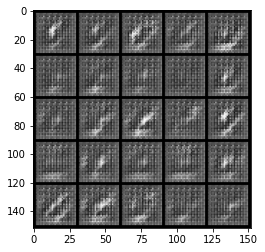

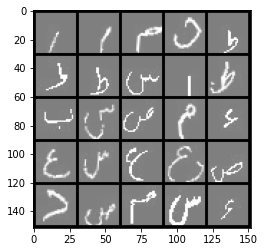

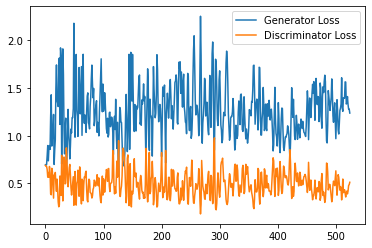

  0%|          | 0/465 [00:00<?, ?it/s]

Step 11000: Generator loss: 1.4661191719770432, discriminator loss: 0.4129681581556797


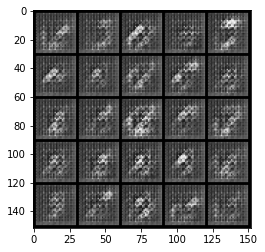

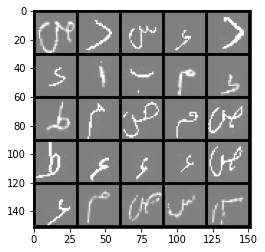

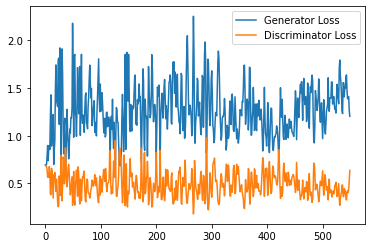

  0%|          | 0/465 [00:00<?, ?it/s]

Step 11500: Generator loss: 1.458854014158249, discriminator loss: 0.4445400505065918


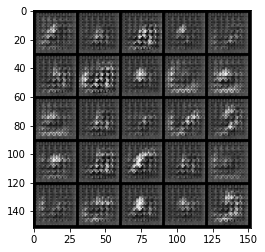

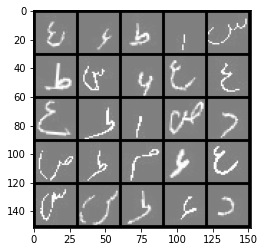

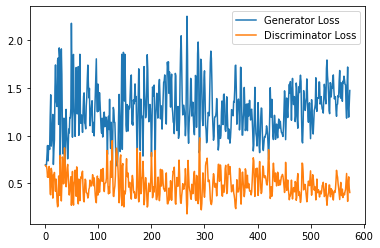

  0%|          | 0/465 [00:00<?, ?it/s]

Step 12000: Generator loss: 1.5749813539981843, discriminator loss: 0.4020779342353344


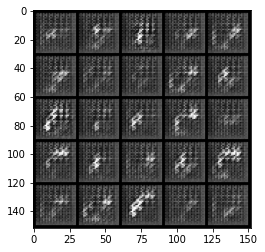

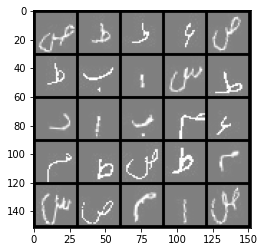

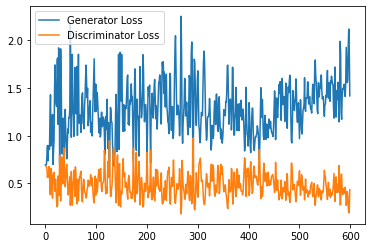

  0%|          | 0/465 [00:00<?, ?it/s]

Step 12500: Generator loss: 1.379098126411438, discriminator loss: 0.4575677002668381


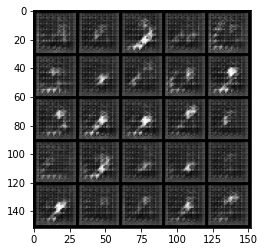

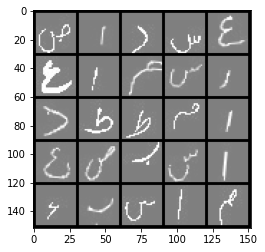

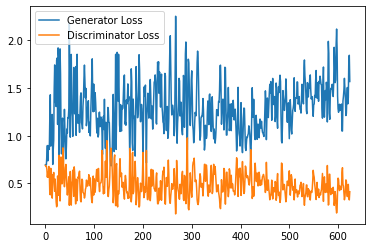

  0%|          | 0/465 [00:00<?, ?it/s]

Step 13000: Generator loss: 1.5976107221841813, discriminator loss: 0.40470149770379066


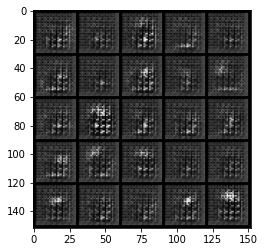

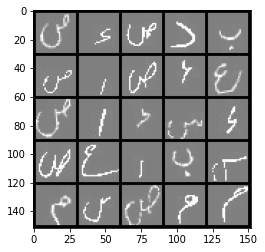

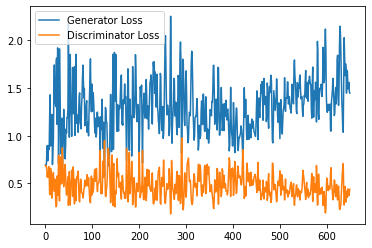

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

Step 13500: Generator loss: 1.6097607144117356, discriminator loss: 0.41681908813118934


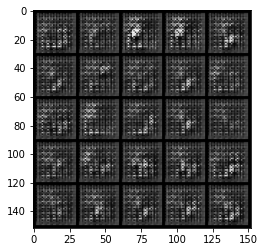

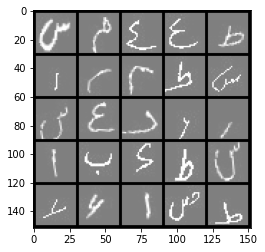

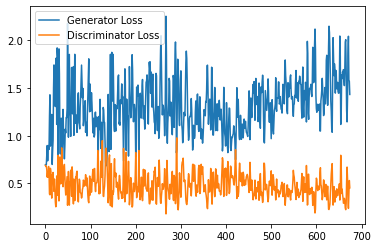

  0%|          | 0/465 [00:00<?, ?it/s]

Step 14000: Generator loss: 1.3939228962659835, discriminator loss: 0.4605803307890892


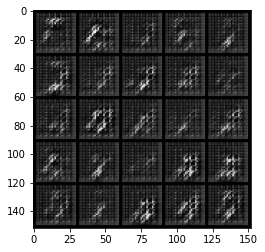

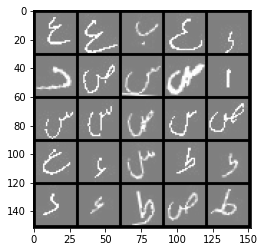

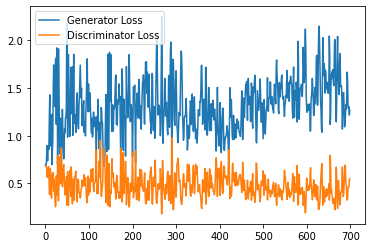

  0%|          | 0/465 [00:00<?, ?it/s]

Step 14500: Generator loss: 1.5264168117046357, discriminator loss: 0.41549832770228384


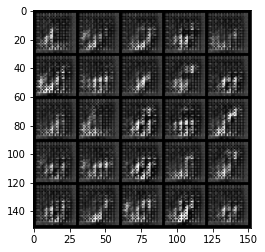

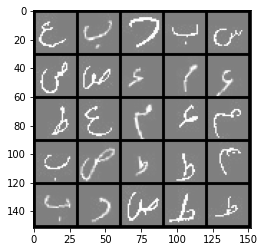

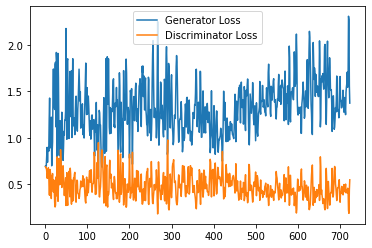

  0%|          | 0/465 [00:00<?, ?it/s]

Step 15000: Generator loss: 1.542307685136795, discriminator loss: 0.4167189179956913


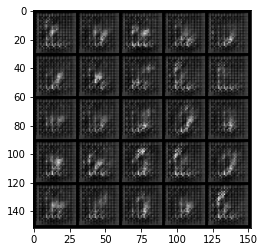

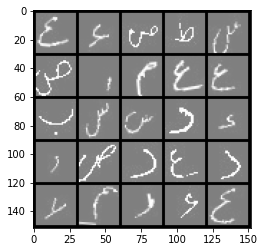

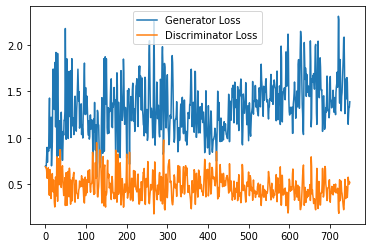

  0%|          | 0/465 [00:00<?, ?it/s]

Step 15500: Generator loss: 1.5381998362541198, discriminator loss: 0.42635625714063646


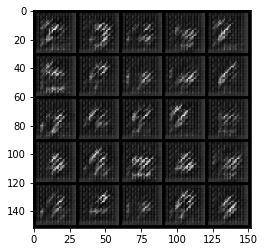

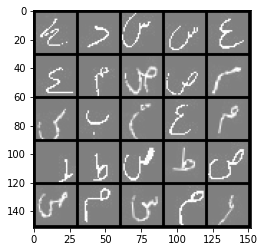

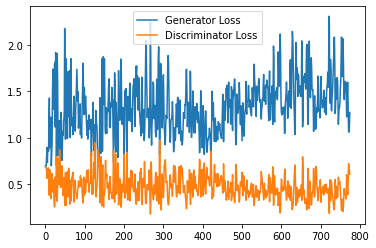

  0%|          | 0/465 [00:00<?, ?it/s]

Step 16000: Generator loss: 1.6093273401260375, discriminator loss: 0.3834679755270481


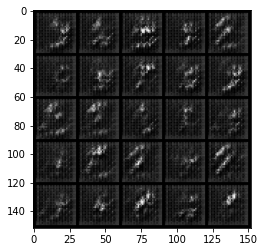

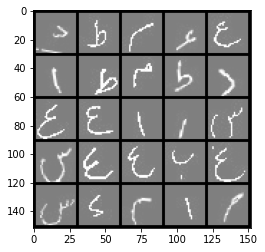

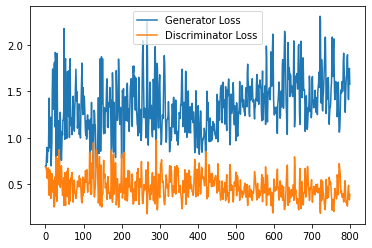

  0%|          | 0/465 [00:00<?, ?it/s]

Step 16500: Generator loss: 1.5389867613315582, discriminator loss: 0.4116737575531006


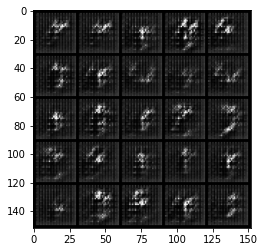

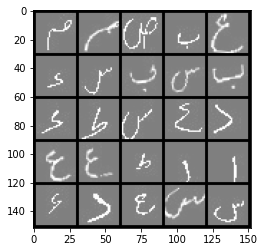

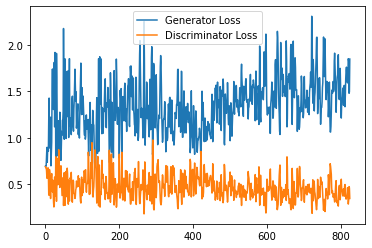

  0%|          | 0/465 [00:00<?, ?it/s]

Step 17000: Generator loss: 1.6146895899772644, discriminator loss: 0.3994103365838528


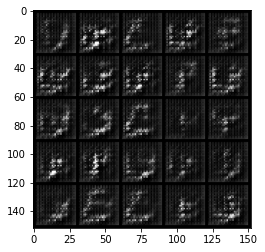

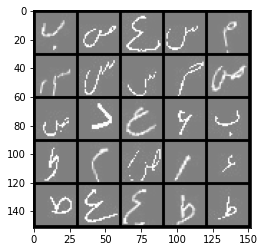

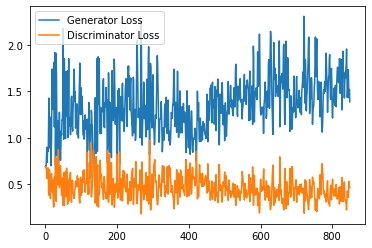

  0%|          | 0/465 [00:00<?, ?it/s]

Step 17500: Generator loss: 1.4813062717914582, discriminator loss: 0.43524289947748185


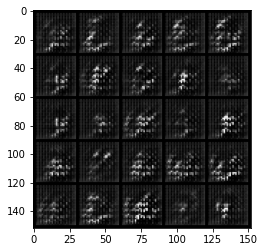

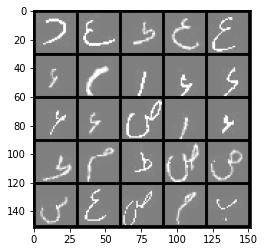

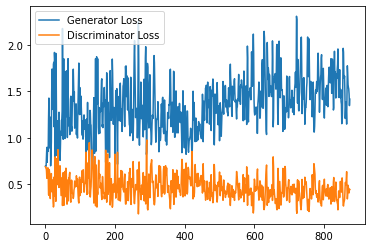

  0%|          | 0/465 [00:00<?, ?it/s]

Step 18000: Generator loss: 1.652546598672867, discriminator loss: 0.39799407789111135


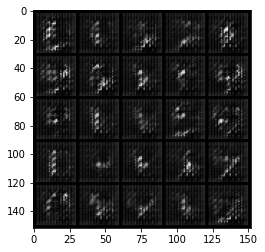

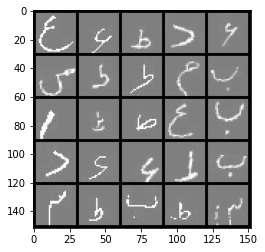

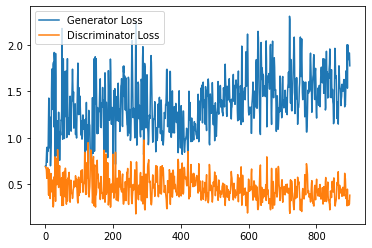

  0%|          | 0/465 [00:00<?, ?it/s]

Step 18500: Generator loss: 1.5196348254680634, discriminator loss: 0.4220230526924133


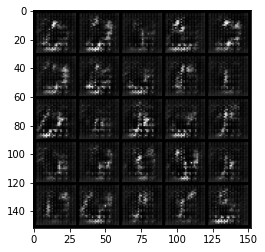

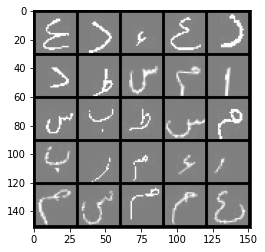

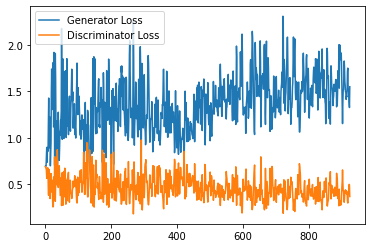

  0%|          | 0/465 [00:00<?, ?it/s]

Step 19000: Generator loss: 1.6226991419792176, discriminator loss: 0.38684677439928056


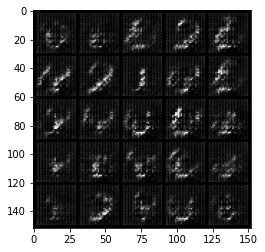

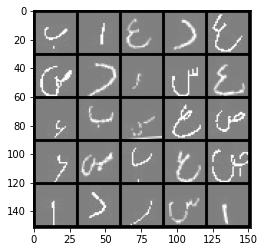

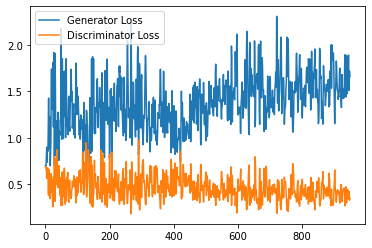

  0%|          | 0/465 [00:00<?, ?it/s]

Step 19500: Generator loss: 1.5777335867881774, discriminator loss: 0.38834434098005294


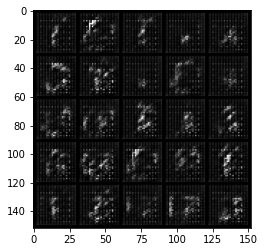

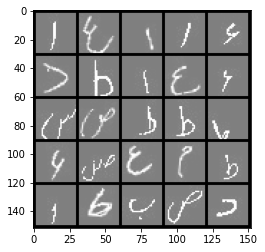

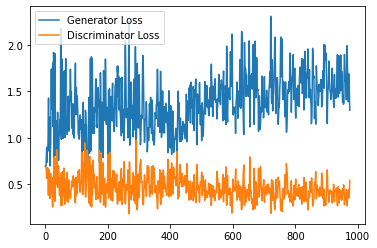

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

Step 20000: Generator loss: 1.5657775719165803, discriminator loss: 0.41784120044112205


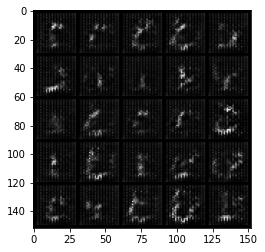

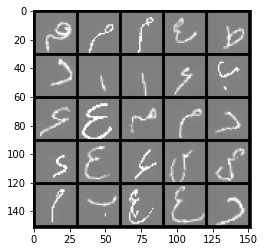

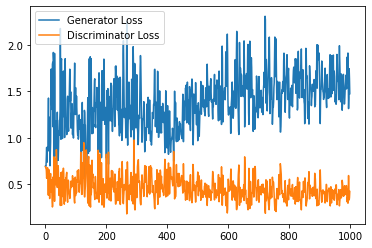

  0%|          | 0/465 [00:00<?, ?it/s]

Step 20500: Generator loss: 1.5219119710922242, discriminator loss: 0.40088482198119163


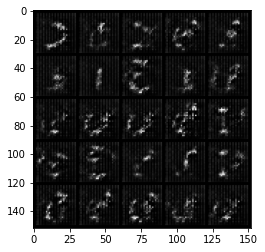

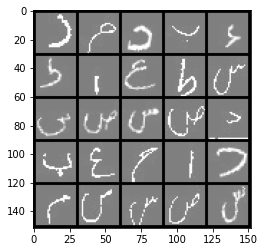

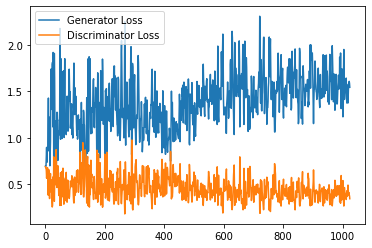

  0%|          | 0/465 [00:00<?, ?it/s]

Step 21000: Generator loss: 1.5806698813438416, discriminator loss: 0.3674863688647747


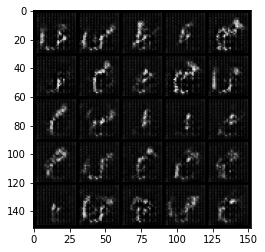

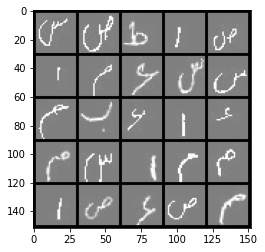

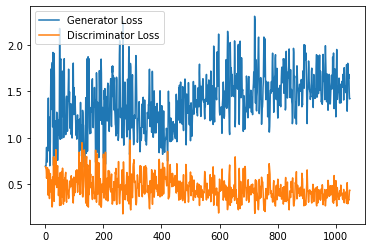

  0%|          | 0/465 [00:00<?, ?it/s]

Step 21500: Generator loss: 1.7300503087043761, discriminator loss: 0.3636223968565464


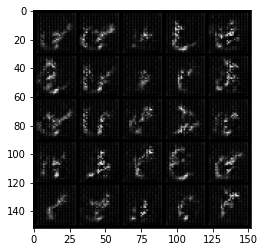

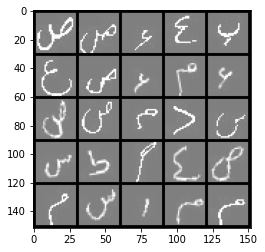

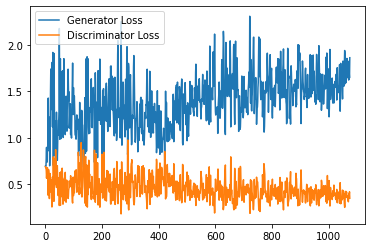

  0%|          | 0/465 [00:00<?, ?it/s]

Step 22000: Generator loss: 1.5904649045467376, discriminator loss: 0.3899388709664345


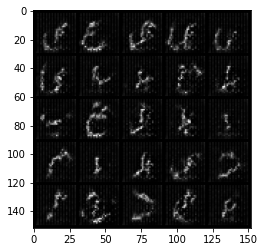

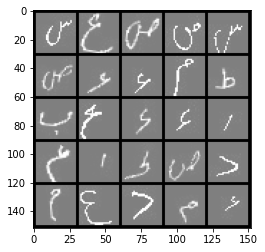

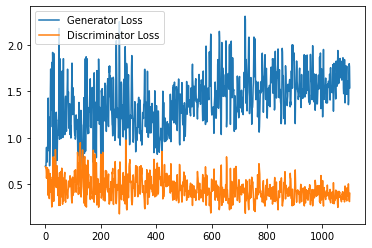

  0%|          | 0/465 [00:00<?, ?it/s]

Step 22500: Generator loss: 1.534317579984665, discriminator loss: 0.4046685651540756


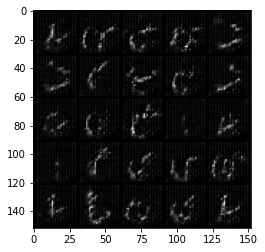

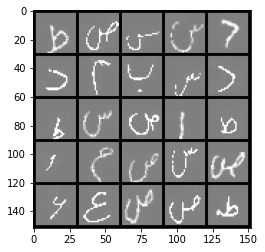

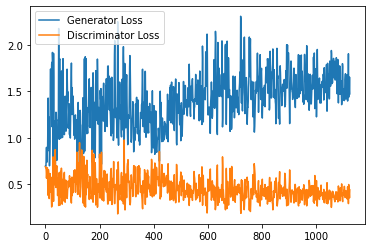

  0%|          | 0/465 [00:00<?, ?it/s]

Step 23000: Generator loss: 1.492188044309616, discriminator loss: 0.42667181634902956


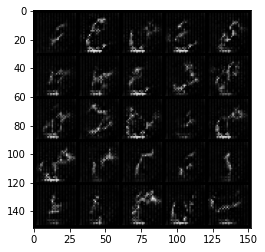

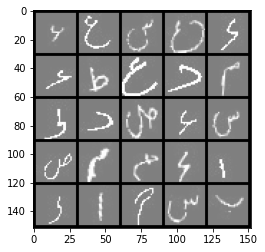

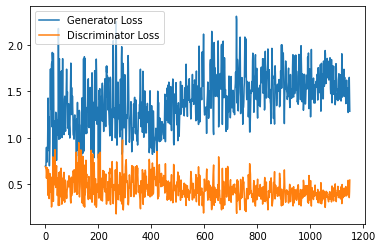

  0%|          | 0/465 [00:00<?, ?it/s]

Step 23500: Generator loss: 1.515662526845932, discriminator loss: 0.44793258762359617


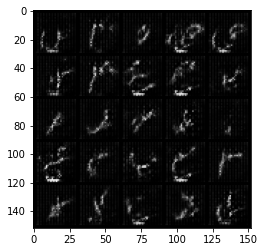

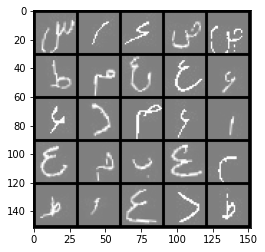

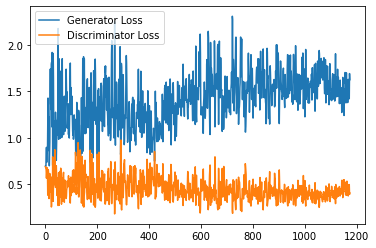

  0%|          | 0/465 [00:00<?, ?it/s]

Step 24000: Generator loss: 1.4854379179477692, discriminator loss: 0.4324843381643295


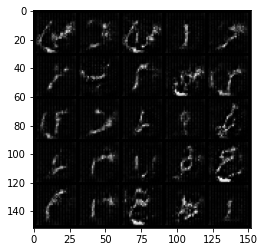

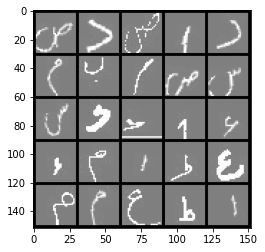

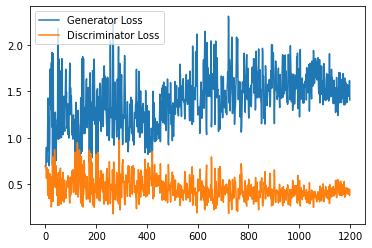

  0%|          | 0/465 [00:00<?, ?it/s]

Step 24500: Generator loss: 1.393899807691574, discriminator loss: 0.4490862382054329


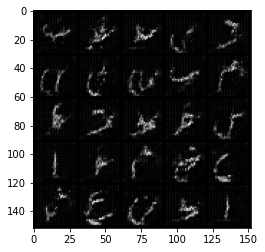

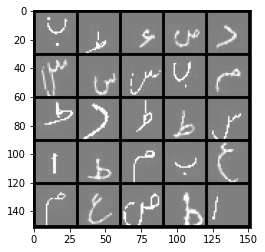

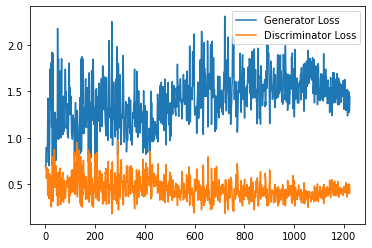

  0%|          | 0/465 [00:00<?, ?it/s]

In [ ]:

cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(1000):

    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])


        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
       
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        
        assert len(fake) == len(real)
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        assert tuple(fake.shape) == (len(real), 1, 28, 28)

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)

        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 28 ,28)

        assert len(disc_real_pred) == len(real)

        assert torch.any(fake_image_and_labels != real_image_and_labels)

        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)
        
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 


        discriminator_losses += [disc_loss.item()]

        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            torch.save(gen.state_dict(), '/content/drive/MyDrive/ganGenerator.pt')
            torch.save(disc.state_dict(), '/content/drive/MyDrive/ganDiscriminator.pt')
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

In [ ]:
gen = gen.eval()